In [9]:
# This notebook is designed to preprocess the day-long miniseed data for the input of EQTransformer first and then apply 
# EqTransformer to dectect and associate local earthquakes.I have used only 3 test stations in Myanmar.
# I have used Tensorflow 2.5 which performs much faster that previous versions. 
# renmae and copy the miniseed files to the individial station direcotries 

import os
import shutil
from datetime import datetime
from pathlib import Path

# Set input and output directories
cdir = Path().resolve()
input_dir = Path(cdir, "BIMA_miniseed")
output_dir = Path(cdir, "BIMA_miniseed_processed")
output_dir.mkdir(exist_ok=True)


# Process each MiniSEED file
# format :: MP02.XR..HH1.2019.055
for file in input_dir.glob("*.*..*.*.*"):  # Format: Station.Network..Channel.Year.Julianday
    parts = file.name.split(".")
    if len(parts) != 6:
        print(f"Skipping unrecognized format: {file.name}")
        continue

    station, network, _, channel, year, jday = parts

    # Convert Jday to cdate
    try:
        date_obj = datetime.strptime(f"{year}.{jday}", "%Y.%j")
        date_str = date_obj.strftime("%Y%m%d")
        iso_date = f"{date_str}T000000Z"
    except Exception as e:
        print(f"Failed to convert date for {file.name}: {e}")
        continue

    # Create station-specific output directory
    station_dir = output_dir / station
    station_dir.mkdir(parents=True, exist_ok=True)

    # rename and move the file to the individual directories
    new_filename = f"{network}.{station}..{channel}__{iso_date}__{iso_date}.mseed"
    new_file_path = station_dir / new_filename
    #file.rename(new_file_path)
    shutil.copy2(file, new_file_path)  
    print(f"Copied: {file.name} → {new_file_path.relative_to(cdir)}")

print('All miniseed files are renamed and organised in a station sub-directory')


Moved: MP02.XR..HH1.2019.055 → BIMA_miniseed_processed\MP02\XR.MP02..HH1__20190224T000000Z__20190224T000000Z.mseed
Moved: MP02.XR..HH1.2019.056 → BIMA_miniseed_processed\MP02\XR.MP02..HH1__20190225T000000Z__20190225T000000Z.mseed
Moved: MP02.XR..HH1.2019.057 → BIMA_miniseed_processed\MP02\XR.MP02..HH1__20190226T000000Z__20190226T000000Z.mseed
Moved: MP02.XR..HH2.2019.055 → BIMA_miniseed_processed\MP02\XR.MP02..HH2__20190224T000000Z__20190224T000000Z.mseed
Moved: MP02.XR..HH2.2019.056 → BIMA_miniseed_processed\MP02\XR.MP02..HH2__20190225T000000Z__20190225T000000Z.mseed
Moved: MP02.XR..HH2.2019.057 → BIMA_miniseed_processed\MP02\XR.MP02..HH2__20190226T000000Z__20190226T000000Z.mseed
Moved: MP02.XR..HHZ.2019.055 → BIMA_miniseed_processed\MP02\XR.MP02..HHZ__20190224T000000Z__20190224T000000Z.mseed
Moved: MP02.XR..HHZ.2019.056 → BIMA_miniseed_processed\MP02\XR.MP02..HHZ__20190225T000000Z__20190225T000000Z.mseed
Moved: MP02.XR..HHZ.2019.057 → BIMA_miniseed_processed\MP02\XR.MP02..HHZ__201902

In [6]:
# make the miniseed file list 
# not needed

import os

def list_files_to_text(folder_path, output_file):
    """Lists all files in a folder and saves the list to a text file.

    Args:
        folder_path (str): The path to the folder.
        output_file (str): The path to the output text file.
    """
    try:
        with open(output_file, 'w') as f:
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if os.path.isfile(file_path): # Check if it's a file
                    f.write(filename + '\n')
        print(f"File list saved to: {output_file}")
    except FileNotFoundError:
        print(f"Error: Folder not found at {folder_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

folder_path=input_dir
output_file=os.path.join(cdir, "file_list.txt")
list_files_to_text(folder_path, output_file)

File list saved to: C:\Users\mohim\OneDrive - University of Missouri\ML_Phase_Picking\file_list.txt


In [11]:
# convert the staton list file to the json format compatable with EQT

import json
from pathlib import Path

# Set paths
cdir = Path().resolve()
coord_file = cdir / "bima_mn_latlon"
output_dir = cdir / "json_bima"
output_dir.mkdir(exist_ok=True)
output_json = output_dir / "station_list.json"

# Static values
network = "XR"
channels = ["HH1", "HH2", "HHZ"]

# Build station dictionary from coordinate file
station_dict = {}

with open(coord_file, "r") as f:
    for line in f:
        if not line.strip():
            continue
        parts = line.strip().split()
        if len(parts) < 4:
            print(f"Skipping invalid line: {line.strip()}")
            continue
        station = parts[0]
        lat = float(parts[1])
        lon = float(parts[2])
        elev = float(parts[3])

        station_dict[station] = {
            "network": network,
            "channels": channels,
            "coords": [lat, lon, elev]
        }

# Save to JSON
with open(output_json, "w") as f:
    json.dump(station_dict, f, indent=4)

print(f"station list saved to: {output_json}")



station list saved to: C:\Users\mohim\OneDrive - University of Missouri\ML_Phase_Picking\json_bima\station_list.json


In [12]:
# preprocess 

# converting all miniseed to hdf files 
# the hdf file will be saved in "miniseed_dir" + "hfs"

from EQTransformer.utils.hdf5_maker import preprocessor
# help(preprocessor)

json_basepath = os.path.join(os.getcwd(),"json_bima/station_list.json")
preprocessor(preproc_dir="preproc_bima",
             mseed_dir='BIMA_miniseed_processed', 
             stations_json=json_basepath, 
             overlap=0.3, 
             n_processor=2)


============ Station MP02 has 3 chunks of data.
============ Station MP03 has 3 chunks of data.
  * MP02 (1) .. 20190224 --> 20190224 .. 3 components .. sampling rate: 100.0
  * MP03 (1) .. 20190224 --> 20190224 .. 3 components .. sampling rate: 100.0
  * MP03 (2) .. 20190225 --> 20190225 .. 3 components .. sampling rate: 100.0
  * MP02 (2) .. 20190225 --> 20190225 .. 3 components .. sampling rate: 100.0
  * MP03 (3) .. 20190226 --> 20190226 .. 3 components .. sampling rate: 100.0
  * MP02 (3) .. 20190226 --> 20190226 .. 3 components .. sampling rate: 100.0
 Station MP03 had 3 chuncks of data
6169 slices were written, 6171.0 were expected.
Number of 1-components: 0. Number of 2-components: 0. Number of 3-components: 3.
Original samplieng rate: 100.0.
============ Station MP04 has 3 chunks of data.
  * MP04 (1) .. 20190224 --> 20190224 .. 3 components .. sampling rate: 100.0
 Station MP02 had 3 chuncks of data
6171 slices were written, 6171.0 were expected.
Number of 1-components: 0. Nu

In [ ]:
# Older vesion of EQtransformer (1.5x- downloaded from the conda forge) has some bugs for running in the windows system. 
# Run this monkey patch that fixes the illigal filename issues (name with ":") while saving the sample figure. 
# note: there might be other issues which you may encounter. 

import EQTransformer.core.predictor as predictor_module
from EQTransformer.core.predictor import predictor  # the function

import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Custom plotter that sanitizes filename
def safe_plotter_prediction(data, evi, args, save_figs, yh1, yh2, yh3,
                            yh1_std, yh2_std, yh3_std, matches):
    safe_evi = re.sub(r'[<>:"/\\|?*]', '_', str(evi))

    dt = args["input_dimention"][0] / args["sampling_rate"]
    t = np.linspace(0, dt * (len(data[0]) - 1), len(data[0]))

    fig = plt.figure(figsize=(12, 8))
    for i, channel in enumerate(['Z', 'N', 'E']):
        ax = plt.subplot(3, 1, i + 1)
        ax.plot(t, data[i], 'k', linewidth=0.8, label='Waveform')
        ax.plot(t, yh1[i], 'b', linewidth=0.8, label='P prob')
        ax.plot(t, yh2[i], 'r', linewidth=0.8, label='S prob')
        ax.plot(t, yh3[i], 'g', linewidth=0.8, label='Event prob')
        ax.set_ylabel(f"{channel}-channel")
        ax.legend(loc='upper right')
        ax.set_xlim([0, t[-1]])

    plt.xlabel("Time (s)")
    plt.suptitle(f"Detection ID: {safe_evi}", fontsize=12)
    plt.tight_layout()

    save_path = os.path.join(save_figs, safe_evi + ".png")
    fig.savefig(save_path)
    plt.close(fig)
    plt.clf()
    return fig

# Monkey patch _gen_writer from the actual predictor module
def patched_gen_writer(new_list, args, prob_dic, pred_set, HDF_PROB,
                       predict_writer, save_figs, csvPr_gen,
                       plt_n, detection_memory, keepPS, spLimit):

    for ts in new_list:
        if prob_dic["event_label"][ts] == 1:
            evi = str(ts)
            if args["number_of_plots"] > 0 and plt_n < args["number_of_plots"]:
                safe_plotter_prediction(
                    pred_set[ts], evi, args, save_figs,
                    prob_dic["PP_prob"][ts],
                    prob_dic["SS_prob"][ts],
                    prob_dic["EE_prob"][ts],
                    prob_dic["PP_std"][ts],
                    prob_dic["SS_std"][ts],
                    prob_dic["EE_std"][ts],
                    matches=None
                )
                plt_n += 1
            detection_memory.append(ts)

    return plt_n, detection_memory

# Apply the patch directly
predictor_module._gen_writer = patched_gen_writer

# Detection section

In [1]:
# Now detect the eathquake candidates using deep nural netwrok based model (EQT)

# first there is a bug the original EQT code that prevents saving the sample waveforms in widows seeting

import os
import stat
import shutil
#from EQTransformer.core.predictor import predictor
from EQTransformer.core.predictor import predictor


#help(predictor)
cdir=os.getcwd()

out_path =os.path.join(cdir, "detections_bima")  # output directory
                       
# Check if directory exists before deleting
if os.path.isdir(out_path):
    shutil.rmtree(out_path)
    print(f"Directory '{out_path}' has been deleted ...")
else:
    print(f"Directory '{out_path}' does not exist.")


model_path=os.path.join(cdir, "EQT_Models", "EqT_original_model.h5")  # EQT model path 

hdf_dir=os.path.join(cdir, "BIMA_miniseed_processed_hdfs")     # hdfs fils dir

predictor(input_dir= hdf_dir, 
          input_model=model_path, output_dir=out_path,
          estimate_uncertainty=False, 
          output_probabilities=False,
          number_of_sampling=5,
          loss_weights=[0.02, 0.40, 0.58],          
          detection_threshold=0.5,                
          P_threshold=0.5,
          S_threshold=0.4, 
          number_of_plots=20,
          plot_mode='time',
          batch_size=500,
          use_multiprocessing=True,
          number_of_cpus=8,
          keepPS=False,
          allowonlyS=False,
          spLimit=60) 

Directory 'C:\Users\mohim\OneDrive - University of Missouri\ML_Phase_Picking\detections_bima' does not exist.
Running EqTransformer  0.1.61
 *** Loading the model ...
*** Loading is complete!
######### There are files for 3 stations in C:\Users\mohim\OneDrive - University of Missouri\ML_Phase_Picking\BIMA_miniseed_processed_hdfs directory. #########
========= Started working on MP02, 1 out of 3 ...
100%|███████████████████████████████████████████████████████████████| 13/13 [07:24<00:00, 32.31s/it]

 *** Finished the prediction in: 0 hours and 7 minutes and 47.7 seconds.
 *** Detected: 1984 events.
 *** Wrote the results into --> " C:\Users\mohim\OneDrive - University of Missouri\ML_Phase_Picking\detections_bima\MP02_outputs "
========= Started working on MP03, 2 out of 3 ...

100%|███████████████████████████████████████████████████████████████| 13/13 [07:47<00:00, 35.98s/it]

100%|███████████████████████████████████████████████████████████████| 13/13 [05:55<00:00, 27.35s/it]

 *** Fini

# Visualizing results to check performance and  set the optimal paremeters 

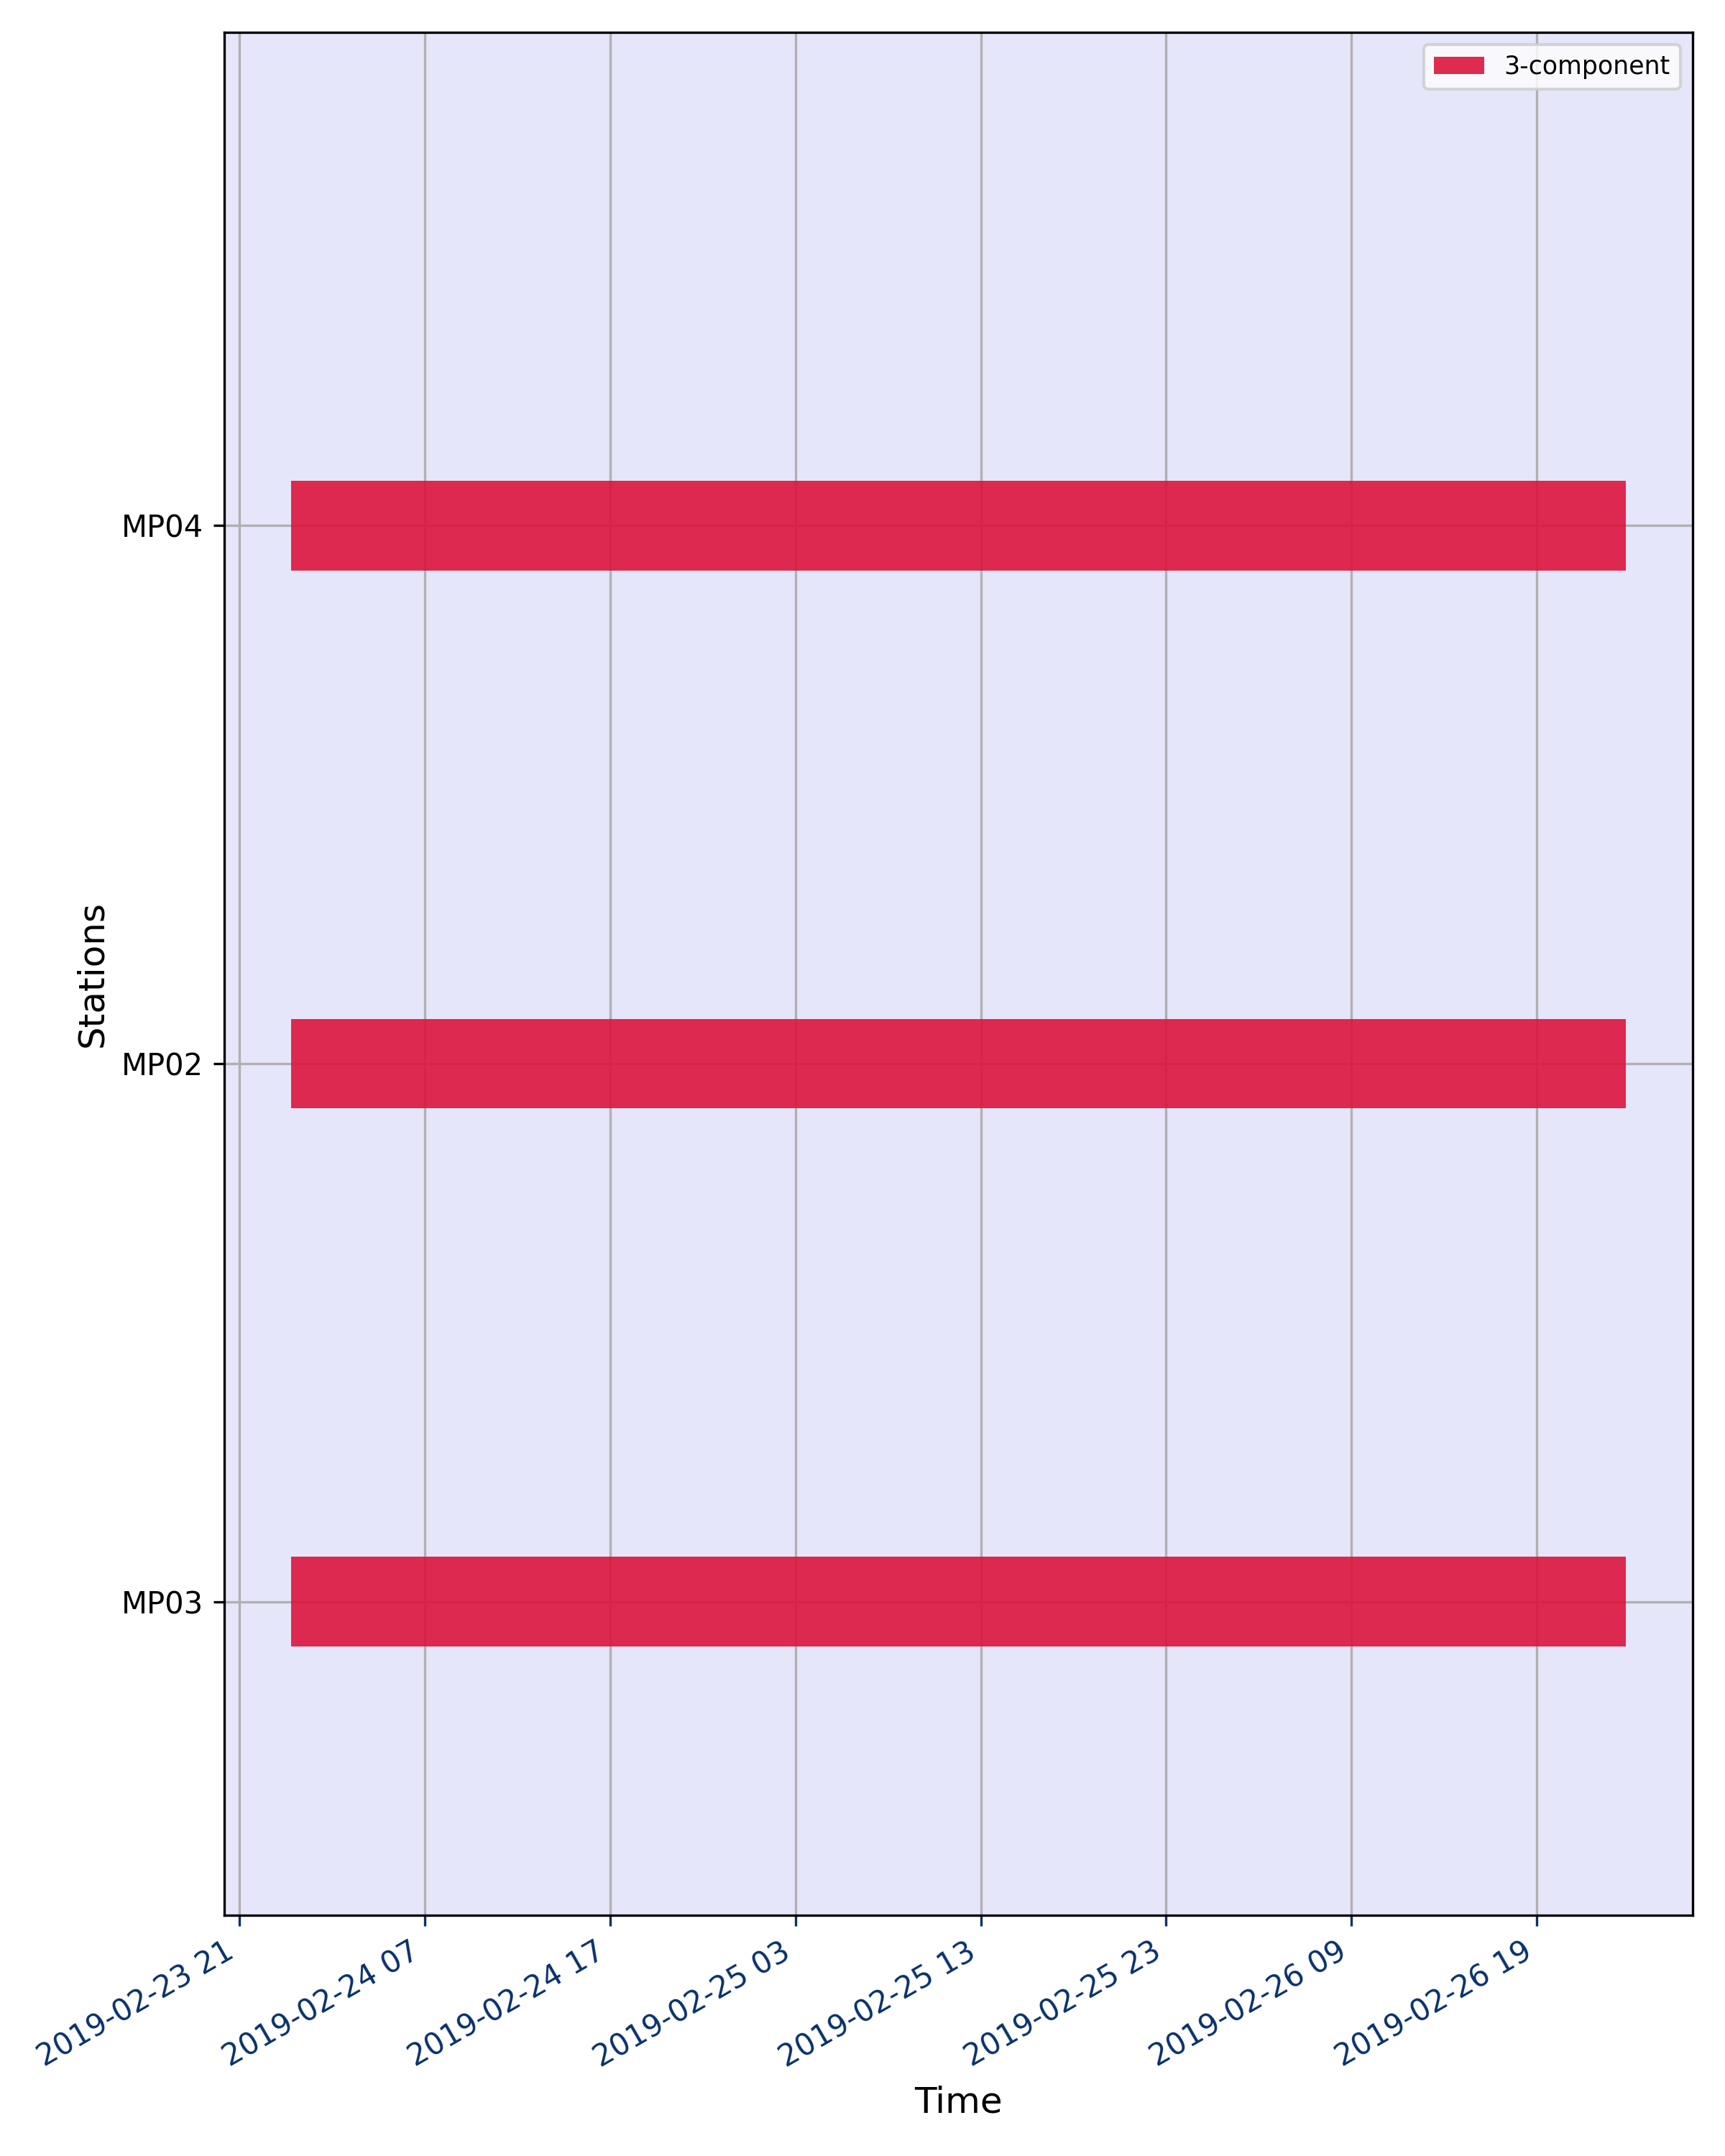

In [24]:
# creating data availblilty digram
from PIL import Image
from IPython.display import display
from EQTransformer.utils.plot import plot_data_chart
plot_data_chart('preproc_bima/time_tracks.pkl', time_interval=10)
img=Image.open('data_chart.png')
display(img)

In [36]:
import glob
import random

from EQTransformer.utils.plot import plot_detections, plot_helicorder

# helicorder plot to see the raw data

n=2 # number of figure you want to plot per staton


mseed_dir=os.path.join(cdir,"BIMA_miniseed_processed")
dec_dir=os.path.join(cdir, "detections_bima")
print(dec_dir)

dir_list = os.listdir(mseed_dir)
for stn in dir_list:
    print('station', stn, '==>')
    sdir=os.path.join(mseed_dir, stn)
    #sfiles=os.listdir(sdir)
    sfiles=glob.glob(sdir +"/*HHZ*")
    
    if n <= len(sfiles):
        indx = random.sample(range(len(sfiles)), n)
        for i in indx:
            print('plotting',sfiles[i].split("\\")[-1], '...')
            #plot_helicorder(input_mseed=sfiles[i], input_csv=None, save_plot=True)  # plot the trace without detected events
            stn2=stn+"_outputs"
            stn_csv_path=os.path.join(dec_dir,stn2,"X_prediction_results.csv")
            
            #print(stn_csv_path)
            plot_helicorder(input_mseed=sfiles[i], input_csv=stn_csv_path,save_plot=True) # plot the trace with deteted events
            
            
    else:
        print(f"Cannot select {n} unique items from a list of length {len(sfiles)}.")
        
        
        
    #sf1, sf = random.sample(range(len(sfiles)), 2)
    #for sf in range(len(sfiles)):
        #a, b = random.sample(sfiles, 2)
    #    print(random.choice(sfiles))
        #print(a)
        #print(b)
        #cc+=1

    #plot_helicorder(input_mseed='downloads_mseeds/CA06/GS.CA06.00.HHZ__20190902T000000Z__20190903T000000Z.mseed', input_csv=None)
#plot_detections(input_dir="detections", input_json="station_list.json", plot_type='hist', time_window=120)

C:\Users\mohim\OneDrive - University of Missouri\ML_Phase_Picking\detections_bima
station MP02 ==>
plotting XR.MP02..HHZ__20190224T000000Z__20190224T000000Z.mseed ...
saved the plot as XR.MP02..HHZ__20190224T000000Z__20190224T000000Z.png
saved the plot as XR.MP02..HHZ__20190224T000000Z__20190224T000000Z.png
plotting XR.MP02..HHZ__20190225T000000Z__20190225T000000Z.mseed ...
saved the plot as XR.MP02..HHZ__20190225T000000Z__20190225T000000Z.png
saved the plot as XR.MP02..HHZ__20190225T000000Z__20190225T000000Z.png
station MP03 ==>
plotting XR.MP03..HHZ__20190225T000000Z__20190225T000000Z.mseed ...
saved the plot as XR.MP03..HHZ__20190225T000000Z__20190225T000000Z.png
saved the plot as XR.MP03..HHZ__20190225T000000Z__20190225T000000Z.png
plotting XR.MP03..HHZ__20190224T000000Z__20190224T000000Z.mseed ...
saved the plot as XR.MP03..HHZ__20190224T000000Z__20190224T000000Z.png
saved the plot as XR.MP03..HHZ__20190224T000000Z__20190224T000000Z.png
station MP04 ==>
plotting XR.MP04..HHZ__2019

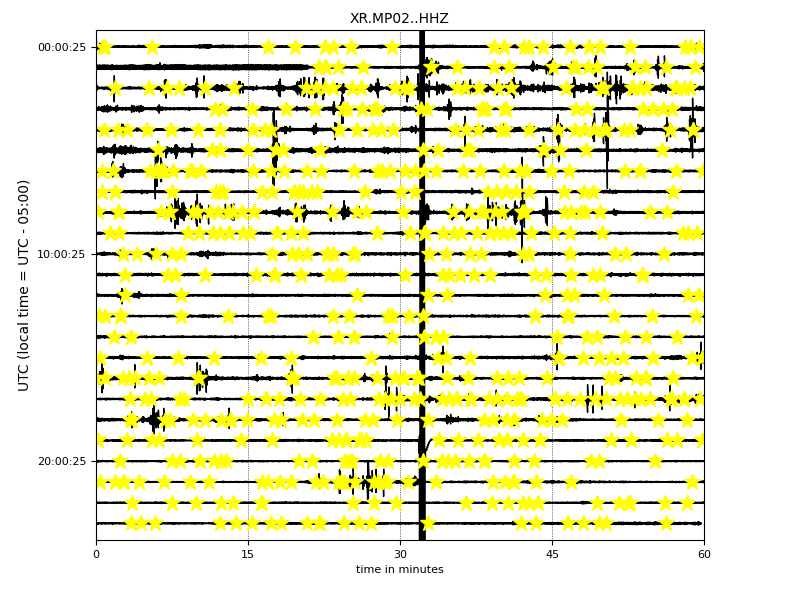

In [38]:
# see one plot 
from PIL import Image
from IPython.display import display
png_path=os.path.join(cdir, "XR.MP02..HHZ__20190225T000000Z__20190225T000000Z.png")
img=Image.open(png_path)
display(img)


## Phase Association 
### This section will assicate the decteced events and output the associated file in Hypoinverse format  

In [45]:
# defining start and end time
STIME="2019-02-24 00:00:00.00"
ETIME="2019-02-27 00:00:00.00"

import shutil
import os
from EQTransformer.utils.associator import run_associator

# detete and make the ouput directory 

out_dir = "asociation_bima"
try:
    shutil.rmtree(out_dir)
except Exception:
    pass
os.makedirs(out_dir) 

run_associator(input_dir='detections_bima', 
               start_time=STIME, 
               end_time=ETIME,
               moving_window = 15,
               pair_n = 3,
               output_dir=out_dir,
               consider_combination=True)

MP02_outputs
reading MP02_outputs ...
MP03_outputs
reading MP03_outputs ...
MP04_outputs
reading MP04_outputs ...


  3%|█▊                                                        | 536/17280 [00:01<00:45, 367.28it/s]

2019-02-24 01:57:12.290000


 12%|██████▋                                                  | 2040/17280 [00:05<00:46, 328.31it/s]

2019-02-24 08:22:42.720000
2019-02-24 08:26:19.600000


 13%|███████▌                                                 | 2305/17280 [00:06<00:43, 340.56it/s]

2019-02-24 09:22:15.460000


 14%|███████▉                                                 | 2415/17280 [00:06<00:44, 333.55it/s]

2019-02-24 09:51:53.700000


 15%|████████▋                                                | 2634/17280 [00:07<00:40, 359.34it/s]

2019-02-24 10:44:19.860000


 19%|██████████▌                                              | 3212/17280 [00:08<00:40, 347.58it/s]

2019-02-24 13:08:38.800000


 20%|███████████▎                                             | 3422/17280 [00:09<00:48, 288.16it/s]

2019-02-24 14:03:10.660000
2019-02-24 14:10:07.610000
2019-02-24 14:14:54.340000


 22%|████████████▋                                            | 3855/17280 [00:10<00:41, 321.56it/s]

2019-02-24 15:49:25.060000
2019-02-24 15:55:44.420000


 23%|█████████████▏                                           | 3998/17280 [00:11<00:40, 330.09it/s]

2019-02-24 16:25:16.540000


 25%|██████████████▍                                          | 4366/17280 [00:12<00:37, 345.72it/s]

2019-02-24 17:56:57.660000


 26%|██████████████▋                                          | 4458/17280 [00:12<00:31, 401.88it/s]

2019-02-24 18:14:18.900000


 29%|████████████████▊                                        | 5093/17280 [00:14<00:35, 339.91it/s]

2019-02-24 21:02:28.060000


 31%|█████████████████▌                                       | 5342/17280 [00:14<00:37, 315.35it/s]

2019-02-24 22:05:26.580000
2019-02-24 22:12:15.140000


 35%|███████████████████▋                                     | 5964/17280 [00:16<00:34, 331.23it/s]

2019-02-25 00:39:35.090000
2019-02-25 00:46:47.920000


 36%|████████████████████▍                                    | 6178/17280 [00:17<00:32, 337.27it/s]

2019-02-25 01:31:09.340000


 37%|█████████████████████▎                                   | 6470/17280 [00:18<00:34, 315.54it/s]

2019-02-25 02:51:11.070000
2019-02-25 02:53:12.090000
2019-02-25 02:57:26.520000


 39%|██████████████████████▏                                  | 6725/17280 [00:18<00:33, 318.44it/s]

2019-02-25 03:46:44.430000
2019-02-25 03:54:09.110000


 41%|███████████████████████▌                                 | 7162/17280 [00:20<00:32, 310.21it/s]

2019-02-25 05:37:10.690000
2019-02-25 05:44:10.270000
2019-02-25 05:46:05.210000


 42%|███████████████████████▋                                 | 7199/17280 [00:20<00:31, 323.89it/s]

2019-02-25 06:02:03.730000


 43%|████████████████████████▎                                | 7372/17280 [00:20<00:36, 275.13it/s]

2019-02-25 06:33:39.730000


 44%|█████████████████████████                                | 7583/17280 [00:21<00:30, 322.28it/s]

2019-02-25 07:28:02.310000
2019-02-25 07:42:29.530000


 45%|█████████████████████████▌                               | 7753/17280 [00:22<00:29, 326.23it/s]

2019-02-25 08:07:24.610000
2019-02-25 08:20:01.690000


 46%|██████████████████████████                               | 7913/17280 [00:22<00:23, 390.35it/s]

2019-02-25 08:42:18.140000
2019-02-25 09:02:39.290000


 48%|███████████████████████████▏                             | 8227/17280 [00:23<00:25, 352.00it/s]

2019-02-25 09:58:09.850000


 49%|███████████████████████████▉                             | 8465/17280 [00:24<00:24, 362.15it/s]

2019-02-25 10:59:30.320000
2019-02-25 11:17:41.330000
2019-02-25 11:17:45.630000


 49%|████████████████████████████▏                            | 8538/17280 [00:24<00:27, 321.08it/s]

2019-02-25 11:20:31.740000


 50%|████████████████████████████▋                            | 8683/17280 [00:24<00:25, 331.13it/s]

2019-02-25 11:59:04.960000


 52%|█████████████████████████████▌                           | 8944/17280 [00:25<00:23, 359.59it/s]

2019-02-25 13:02:37.030000


 52%|█████████████████████████████▉                           | 9057/17280 [00:25<00:23, 345.22it/s]

2019-02-25 13:29:18.300000


 53%|██████████████████████████████                           | 9130/17280 [00:26<00:24, 332.25it/s]

2019-02-25 13:46:51.090000


 54%|██████████████████████████████▌                          | 9252/17280 [00:26<00:24, 332.93it/s]

2019-02-25 14:25:35.410000
2019-02-25 14:29:12.810000


 54%|██████████████████████████████▉                          | 9392/17280 [00:26<00:25, 308.74it/s]

2019-02-25 14:54:11.560000
2019-02-25 14:57:35.170000


 57%|████████████████████████████████▎                        | 9781/17280 [00:28<00:25, 295.29it/s]

2019-02-25 16:40:41.250000


 57%|████████████████████████████████▌                        | 9882/17280 [00:28<00:23, 309.65it/s]

2019-02-25 17:02:04.170000
2019-02-25 17:05:09.810000


 58%|████████████████████████████████▌                       | 10065/17280 [00:28<00:22, 326.77it/s]

2019-02-25 17:44:22.830000
2019-02-25 17:45:29.970000


 59%|████████████████████████████████▉                       | 10168/17280 [00:29<00:21, 327.09it/s]

2019-02-25 18:12:15.570000


 62%|██████████████████████████████████▉                     | 10762/17280 [00:30<00:18, 352.23it/s]

2019-02-25 20:38:36.810000


 63%|███████████████████████████████████▍                    | 10944/17280 [00:31<00:17, 356.80it/s]

2019-02-25 21:24:47.980000


 65%|████████████████████████████████████▋                   | 11317/17280 [00:32<00:16, 370.10it/s]

2019-02-25 22:58:08.910000


 66%|████████████████████████████████████▉                   | 11407/17280 [00:32<00:15, 372.97it/s]

2019-02-25 23:22:24.780000


 68%|█████████████████████████████████████▊                  | 11669/17280 [00:33<00:16, 333.12it/s]

2019-02-26 00:28:23.810001
2019-02-26 00:36:30.900001


 68%|██████████████████████████████████████▏                 | 11776/17280 [00:33<00:16, 335.22it/s]

2019-02-26 00:48:17.620001


 69%|██████████████████████████████████████▍                 | 11845/17280 [00:33<00:16, 323.11it/s]

2019-02-26 01:07:19.170001


 70%|██████████████████████████████████████▉                 | 12030/17280 [00:34<00:17, 298.82it/s]

2019-02-26 02:00:07.120001


 70%|███████████████████████████████████████▏                | 12097/17280 [00:34<00:18, 287.23it/s]

2019-02-26 02:14:48.180001


 71%|███████████████████████████████████████▉                | 12325/17280 [00:35<00:13, 361.65it/s]

2019-02-26 03:06:42.210001


 72%|████████████████████████████████████████▌               | 12508/17280 [00:35<00:13, 343.71it/s]

2019-02-26 03:53:56.710001


 73%|████████████████████████████████████████▉               | 12613/17280 [00:36<00:14, 325.77it/s]

2019-02-26 04:19:49.010001
2019-02-26 04:26:07.960000


 74%|█████████████████████████████████████████▏              | 12722/17280 [00:36<00:13, 333.80it/s]

2019-02-26 04:50:46.650001


 75%|██████████████████████████████████████████              | 12988/17280 [00:37<00:12, 344.71it/s]

2019-02-26 05:57:57.650000


 77%|██████████████████████████████████████████▉             | 13245/17280 [00:38<00:14, 281.54it/s]

2019-02-26 07:06:06.650001
2019-02-26 07:10:05.890001


 79%|████████████████████████████████████████████▏           | 13649/17280 [00:39<00:10, 350.90it/s]

2019-02-26 08:37:32.130001


 80%|████████████████████████████████████████████▋           | 13792/17280 [00:39<00:10, 334.63it/s]

2019-02-26 09:19:52.170001


 81%|█████████████████████████████████████████████▍          | 14016/17280 [00:40<00:09, 357.89it/s]

2019-02-26 10:11:54.810001


 82%|█████████████████████████████████████████████▊          | 14123/17280 [00:40<00:09, 317.30it/s]

2019-02-26 10:39:26.170000
2019-02-26 10:43:09.340001


 83%|██████████████████████████████████████████████▎         | 14306/17280 [00:41<00:08, 363.50it/s]

2019-02-26 11:17:06.050001


 83%|██████████████████████████████████████████████▋         | 14425/17280 [00:41<00:05, 484.39it/s]

2019-02-26 11:37:20.920000
2019-02-26 12:05:49.690000


 85%|███████████████████████████████████████████████▍        | 14644/17280 [00:42<00:08, 311.44it/s]

2019-02-26 12:55:43.320001
2019-02-26 12:57:17.290001


 87%|████████████████████████████████████████████████▊       | 15067/17280 [00:43<00:06, 339.51it/s]

2019-02-26 14:37:38.370001


 88%|█████████████████████████████████████████████████▎      | 15212/17280 [00:43<00:06, 329.13it/s]

2019-02-26 15:12:43.590001


 88%|█████████████████████████████████████████████████▌      | 15284/17280 [00:43<00:06, 310.07it/s]

2019-02-26 15:32:34.310001
2019-02-26 15:38:45.740001
2019-02-26 15:41:06.330000


 89%|█████████████████████████████████████████████████▊      | 15376/17280 [00:44<00:06, 278.19it/s]

2019-02-26 15:52:11.910000
2019-02-26 15:56:20.830000
2019-02-26 16:02:43.910000
2019-02-26 16:06:08.330001


 89%|██████████████████████████████████████████████████      | 15445/17280 [00:44<00:06, 300.43it/s]

2019-02-26 16:11:47.450001
2019-02-26 16:21:03.480000


 90%|██████████████████████████████████████████████████▍     | 15545/17280 [00:44<00:06, 281.68it/s]

2019-02-26 16:38:21.650001


 91%|██████████████████████████████████████████████████▋     | 15653/17280 [00:45<00:04, 325.59it/s]

2019-02-26 16:53:46.890001
2019-02-26 17:02:10.330000


 91%|██████████████████████████████████████████████████▉     | 15731/17280 [00:45<00:04, 352.18it/s]

2019-02-26 17:16:19.250001
2019-02-26 17:30:15.340001


 93%|████████████████████████████████████████████████████▎   | 16123/17280 [00:46<00:03, 325.95it/s]

2019-02-26 19:00:26.310001
2019-02-26 19:07:32.010000
2019-02-26 19:13:52.570001


 95%|████████████████████████████████████████████████████▉   | 16337/17280 [00:47<00:02, 320.15it/s]

2019-02-26 19:51:38.530001
2019-02-26 19:57:13.980000


 95%|█████████████████████████████████████████████████████▍  | 16480/17280 [00:47<00:02, 306.50it/s]

2019-02-26 20:28:01.840001
2019-02-26 20:32:04.690001
2019-02-26 20:35:36.050001


 97%|██████████████████████████████████████████████████████▎ | 16765/17280 [00:48<00:01, 347.29it/s]

2019-02-26 21:41:14.430001


 98%|██████████████████████████████████████████████████████▋ | 16871/17280 [00:48<00:01, 317.84it/s]

2019-02-26 22:02:07.850001
2019-02-26 22:12:21.690001


 99%|███████████████████████████████████████████████████████▎| 17082/17280 [00:49<00:00, 337.82it/s]

2019-02-26 22:52:00.530001


100%|███████████████████████████████████████████████████████▉| 17264/17280 [00:49<00:00, 340.46it/s]

2019-02-26 23:51:39.410000
The Number of Realizations: 113



100%|████████████████████████████████████████████████████████| 17280/17280 [00:49<00:00, 346.01it/s]


In [46]:
# output files will be saved in association direcotry. It will have both json and Hypoinverse formatted file
# see output of the Hypoinverse formatted file 

ass_dir=os.path.join(cdir, "asociation_bima")
hfile=os.path.join(ass_dir,"Y2000.phs")

with open(hfile, "r") as file:
    for i, line in enumerate(file):
        if i >= 30:
            break
        print(line.strip())  # .strip() removes trailing newline


2019 224 15712.2923 17.88 93 38.46 5.000.00
MP04 XR  HHZ IP 02019 224 157 9.72        0.00   0
MP03 XR  HHE     2019 224 157 0.00       16.31ES 1
MP03 XR  HHZ IP 02019 224 15714.34        0.00   0
1
2019 224 82242.7223 17.88 93 38.46 5.000.00
MP02 XR  HHZ IP 02019 224 82242.90        0.00   0
MP04 XR  HHZ IP 02019 224 82244.72        0.00   0
2
2019 224 82619.6023 17.88 93 38.46 5.000.00
MP04 XR  HHZ IP 02019 224 82623.72        0.00   0
MP03 XR  HHZ IP 02019 224 82627.88        0.00   0
3
2019 224 92215.4623 17.88 93 38.46 5.000.00
MP02 XR  HHE     2019 224 922 0.00       21.50ES 0
MP02 XR  HHZ IP 02019 224 92214.90        0.00   0
MP03 XR  HHZ IP 02019 224 92216.34        0.00   0
4
2019 224 92215.4623 17.88 93 38.46 5.000.00
MP02 XR  HHE     2019 224 922 0.00       21.50ES 0
MP02 XR  HHZ IP 02019 224 92214.90        0.00   0
MP04 XR  HHZ IP 12019 224 92216.72        0.00   0
4
2019 224 92215.4623 17.88 93 38.46 5.000.00
MP02 XR  HHE     2019 224 922 0.00       21.50ES 0
MP02 XR  HHZ

## Finished! 
### Now you can use the assiciated phase information to in HYPOINVERSE to locate earthquakes and determine magnitudes

In [39]:
from EQTransformer.core.predictor import predictor
from EQTransformer.utils.associator import run_associator
#help(predictor)
help(run_associator)

Help on function run_associator in module EQTransformer.utils.associator:

run_associator(input_dir, start_time, end_time, moving_window=15, pair_n=3, output_dir='.', consider_combination=False)
    It performs a very simple association based on detection times on multiple stations. It works fine when you have a small and local network of seismic stations. 
    
    Parameters
    ----------
    input_dir: str, default=None
        Directory name containing hdf5 and csv files-preprocessed data.
        
    start_time: str, default=None
        Start of a time period of interest in 'YYYY-MM-DD hh:mm:ss.f' format.
        
    end_time: str, default=None
        End of a timeperiod of interest in 'YYYY-MM-DD hh:mm:ss.f' format. 
        
    moving_window: int, default=15
        The length of time window used for association in second. 
        
    pair_n: int, default=2
        The minimum number of stations used for the association. 
        
    output_dir: str, default='.'
       